In [1]:
#%%
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

**Embedding层**

In [2]:
#%%
x = tf.range(10)
x = tf.random.shuffle(x)
# 创建共10个单词，每个单词用长度为4的向量表示的层
net = layers.Embedding(10, 4)
out = net(x)
out.shape

TensorShape([10, 4])

**SimpleRNNCell**

In [3]:
cell = layers.SimpleRNNCell(3)
cell.build(input_shape=(None, 4))
cell.trainable_variables

[<tf.Variable 'kernel:0' shape=(4, 3) dtype=float32, numpy=
 array([[-0.5665946 , -0.6135884 ,  0.6367841 ],
        [ 0.33038437,  0.08950293,  0.36359727],
        [-0.13215643, -0.7785073 ,  0.84523   ],
        [-0.5895711 ,  0.40713537,  0.20422828]], dtype=float32)>,
 <tf.Variable 'recurrent_kernel:0' shape=(3, 3) dtype=float32, numpy=
 array([[-0.38244772, -0.8577773 , -0.3434414 ],
        [ 0.08098897, -0.40138915,  0.9123199 ],
        [ 0.9204209 , -0.32109964, -0.22298081]], dtype=float32)>,
 <tf.Variable 'bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

In [4]:
h0 = [tf.zeros([4, 64])]
x = tf.random.normal([4, 80, 100])
xt = x[:,0,:]
# 构建输入特征f=100,序列长度s=80,状态长度=64的Cell
cell = layers.SimpleRNNCell(64)
out, h1 = cell(xt, h0) # 前向计算
print(out.shape, h1[0].shape)
print(id(out), id(h1[0]))

(4, 64) (4, 64)
139809228827152 139809228827152


In [5]:
#%%
h = h0
# i=0
# 在序列长度的维度解开输入，得到xt:[b,f]
for xt in tf.unstack(x, axis=1):
    out, h = cell(xt, h) # 前向计算
#     print(i)
#     i=i+1
# 最终输出可以聚合每个时间戳上的输出，也可以只取最后时间戳的输出
out = out

**多层SimpleRNN**

In [6]:
#%%
x = tf.random.normal([4,80,100])
xt = x[:,0,:] # 取第一个时间戳的输入x0
print(xt.shape)
# 构建2个Cell,先cell0,后cell1
cell0 = layers.SimpleRNNCell(64)
cell1 = layers.SimpleRNNCell(64)
h0 = [tf.zeros([4,64])] # cell0的初始状态向量
h1 = [tf.zeros([4,64])] # cell1的初始状态向量

out0, h0 = cell0(xt, h0)
out1, h1 = cell1(out0, h1)

(4, 100)


In [7]:
#%%
for xt in tf.unstack(x, axis=1):
#     print(xt.shape)
    # xtw作为输入，输出为out0
    out0, h0 = cell0(xt, h0)
    # 上一个cell的输出out0作为本cell的输入
    out1, h1 = cell1(out0, h1)

In [8]:
#第二种
print(x.shape)
# 保存上一层的所有时间戳上面的输出
middle_sequences = []
# 计算第一层的所有时间戳上的输出，并保存
for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    middle_sequences.append(out0)
# 计算第二层的所有时间戳上的输出
# 如果不是末层，需要保存所有时间戳上面的输出
for xt in middle_sequences:
    out1, h1 = cell1(xt, h1)

(4, 80, 100)


In [9]:
#SimpleRNN层
layer = layers.SimpleRNN(64)
x = tf.random.normal([4, 80, 100])
out = layer(x)
out.shape

TensorShape([4, 64])

In [10]:
layer = layers.SimpleRNN(64,return_sequences=True)
out = layer(x) 
out.shape

TensorShape([4, 80, 64])

In [11]:
#多层
net = keras.Sequential([ # 构建2层RNN网络
# 除最末层外，都需要返回所有时间戳的输出
layers.SimpleRNN(64, return_sequences=True),
layers.SimpleRNN(64),
])
out = net(x)
out.shape

TensorShape([4, 64])

**RNN情感分析实战**

In [12]:
import  os
import  tensorflow as tf
import  numpy as np
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, Sequential

tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')

batchsz = 512 # 批量大小
total_words = 10000 # 词汇表大小N_vocab
max_review_len = 80 # 句子最大长度s，大于的句子部分将截断，小于的将填充
embedding_len = 100 # 词向量特征长度f
# 加载IMDB数据集，此处的数据采用数字编码，一个数字代表一个单词
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=total_words)
print(x_train.shape, len(x_train[0]), y_train.shape)
print(x_test.shape, len(x_test[0]), y_test.shape)

17473536/17464789 [==============================] - 0s 0us/step
(25000,) 218 (25000,)
(25000,) 68 (25000,)


In [13]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [14]:
# 数字编码表
word_index = keras.datasets.imdb.get_word_index()
len(word_index)

1654784/1641221 [==============================] - 0s 0us/step


88584

In [15]:
# for k,v in word_index.items():
#     print(k,v)
#%%
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
# 翻转编码表
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

len(word_index)

88588

In [16]:
reverse_word_index[1]

'<START>'

In [17]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(x_train[8])

"<START> just got out and cannot believe what a brilliant documentary this is rarely do you walk out of a movie theater in such awe and <UNK> lately movies have become so over hyped that the thrill of discovering something truly special and unique rarely happens <UNK> <UNK> did this to me when it first came out and this movie is doing to me now i didn't know a thing about this before going into it and what a surprise if you hear the concept you might get the feeling that this is one of those <UNK> movies about an amazing triumph covered with over the top music and trying to have us fully convinced of what a great story it is telling but then not letting us in <UNK> this is not that movie the people tell the story this does such a good job of capturing every moment of their involvement while we enter their world and feel every second with them there is so much beyond the climb that makes everything they go through so much more tense touching the void was also a great doc about mountain 

In [18]:
# x_train:[b, 80]
# x_test: [b, 80]
# 截断和填充句子，使得等长，此处长句子保留句子后面的部分，短句子在前面填充
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_review_len)
# 构建数据集，打散，批量，并丢掉最后一个不够batchsz的batch
db_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
db_train = db_train.shuffle(1000).batch(batchsz, drop_remainder=True)
db_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
db_test = db_test.batch(batchsz, drop_remainder=True)
print('x_train shape:', x_train.shape, tf.reduce_max(y_train), tf.reduce_min(y_train))
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80) tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)
x_test shape: (25000, 80)


In [19]:
class MyRNN(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNN, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.SimpleRNN(units, dropout=0.5, return_sequences=True),
            layers.SimpleRNN(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 64 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyRNN(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 13s 228ms/step - loss: 0.7072 - accuracy: 0.5062 - val_loss: 0.6921 - val_accuracy: 0.5323
Epoch 2/50
48/48 [==============================] - 11s 223ms/step - loss: 0.6929 - accuracy: 0.5090 - val_loss: 0.6915 - val_accuracy: 0.5396
Epoch 3/50
48/48 [==============================] - 10s 216ms/step - loss: 0.6885 - accuracy: 0.5443 - val_loss: 0.6592 - val_accuracy: 0.6495
Epoch 4/50
48/48 [==============================] - 10s 216ms/step - loss: 0.5435 - accuracy: 0.7373 - val_loss: 0.4023 - val_accuracy: 0.8235
Epoch 5/50
48/48 [==============================] - 11s 222ms/step - loss: 0.3770 - accuracy: 0.8515 - val_loss: 0.3957 - val_accuracy: 0.8330
Epoch 6/50
48/48 [==============================] - 10s 219ms/step - loss: 0.3022 - accuracy: 0.8855 - val_loss: 0.3989 - val_accuracy: 0.8346
Epoch 7/50
48/48 [==============================] - 11s 220ms/step - loss: 0.2475 - accuracy: 0.9119 - val_loss: 0.4634 - val_accuracy: 0.8240

In [20]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 21ms/step - loss: 0.7235 - accuracy: 0.5912


[0.7235429286956787, 0.5911865234375]

**梯度弥散和梯度爆炸**

In [21]:
W = tf.ones([2,2]) # 任意创建某矩阵
eigenvalues = tf.linalg.eigh(W)[0] # 计算特征值
eigenvalues

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

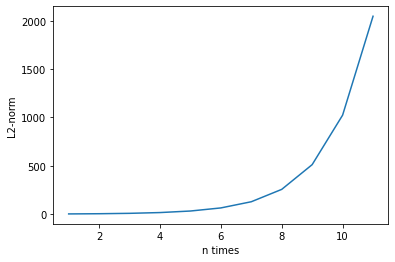

In [22]:
#%%
val = [W]
for i in range(10): # 矩阵相乘n次方
    val.append([val[-1]@W])
# 计算L2范数
norm = list(map(lambda x:tf.norm(x).numpy(),val))
plt.plot(range(1,12),norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# plt.savefig('w_n_times_1.svg')
plt.show()

tf.Tensor([0.  0.8], shape=(2,), dtype=float32)


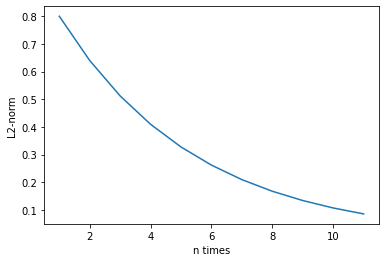

In [23]:
#%%
W = tf.ones([2,2])*0.4 # 任意创建某矩阵
eigenvalues = tf.linalg.eigh(W)[0] # 计算特征值
print(eigenvalues)
val = [W]
for i in range(10):
    val.append([val[-1]@W])
norm = list(map(lambda x:tf.norm(x).numpy(),val))
plt.plot(range(1,12),norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# plt.savefig('w_n_times_0.svg')
plt.show()

In [24]:
#%%
a=tf.random.uniform([2,2])
tf.clip_by_value(a,0.4,0.6) # 梯度值裁剪

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4       , 0.59142506],
       [0.6       , 0.6       ]], dtype=float32)>

In [25]:
a=tf.random.uniform([2,2]) * 5
# 按范数方式裁剪
b = tf.clip_by_norm(a, 5)
tf.norm(a),tf.norm(b)

(<tf.Tensor: shape=(), dtype=float32, numpy=8.08476>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.9999995>)

In [26]:
w1=tf.random.normal([3,3]) # 创建梯度张量1
w2=tf.random.normal([3,3]) # 创建梯度张量2
# 计算global norm
global_norm=tf.math.sqrt(tf.norm(w1)**2+tf.norm(w2)**2) 
# 根据global norm和max norm=2裁剪
(ww1,ww2),global_norm=tf.clip_by_global_norm([w1,w2],2)
# 计算裁剪后的张量组的global norm
global_norm2 = tf.math.sqrt(tf.norm(ww1)**2+tf.norm(ww2)**2)
print(global_norm, global_norm2)

tf.Tensor(3.2026577, shape=(), dtype=float32) tf.Tensor(2.0, shape=(), dtype=float32)


In [27]:
with tf.GradientTape() as tape:
    logits = model(x) # 前向传播
    loss = criteon(y, logits) # 误差计算
# 计算梯度值
grads = tape.gradient(loss, model.trainable_variables)
grads, _ = tf.clip_by_global_norm(grads, 25) # 全局梯度裁剪
# 利用裁剪后的梯度张量更新参数
optimizer.apply_gradients(zip(grads, model.trainable_variables))

ValueError: ignored

In [28]:
#LSTMCell
x = tf.random.normal([2,80,100])
xt = x[:,0,:] # 得到一个时间戳的输入
cell = layers.LSTMCell(64) # 创建Cell
# 初始化状态和输出List,[h,c]
state = [tf.zeros([2,64]),tf.zeros([2,64])]
out, state = cell(xt, state) # 前向计算
id(out),id(state[0]),id(state[1])

(139805611873872, 139805611873872, 139805611873104)

In [29]:
net = layers.LSTM(4)
net.build(input_shape=(None,5,3))
net.trainable_variables

[<tf.Variable 'lstm_cell_1/kernel:0' shape=(3, 16) dtype=float32, numpy=
 array([[-0.04120171,  0.14226496,  0.4595421 , -0.41991758, -0.3068527 ,
          0.05018157,  0.3245529 , -0.10087115,  0.31976527, -0.35862994,
          0.43948013, -0.48714122,  0.4349531 ,  0.26658833, -0.28385186,
         -0.4528833 ],
        [-0.3670842 ,  0.36922383, -0.17499566,  0.40110993,  0.4624216 ,
          0.5540901 , -0.5404531 , -0.5157871 ,  0.00784129, -0.28619236,
          0.4419337 ,  0.30339658, -0.27405167,  0.47935838, -0.37016064,
          0.50813085],
        [ 0.29717064, -0.15825224,  0.3619486 ,  0.3201586 ,  0.47479957,
         -0.07710516,  0.09086865, -0.14772597, -0.21342197,  0.3919397 ,
          0.16756046,  0.11754197, -0.09137428,  0.24521506,  0.2560653 ,
          0.47365707]], dtype=float32)>,
 <tf.Variable 'lstm_cell_1/recurrent_kernel:0' shape=(4, 16) dtype=float32, numpy=
 array([[-0.23742712,  0.12889317, -0.16095483,  0.27700666, -0.06383064,
         -0.03053

In [30]:
net = layers.GRU(4)
net.build(input_shape=(None,5,3))
net.trainable_variables

[<tf.Variable 'gru_cell/kernel:0' shape=(3, 12) dtype=float32, numpy=
 array([[ 0.40103143, -0.46793008,  0.3814847 ,  0.51146156,  0.3826415 ,
          0.3651896 , -0.6017788 ,  0.3965158 , -0.19388166,  0.03471923,
         -0.51278925, -0.1108647 ],
        [ 0.02897578, -0.47327948, -0.50863713, -0.4810816 ,  0.1730637 ,
         -0.12884796,  0.34725022,  0.27582896, -0.33340415, -0.07083064,
          0.46814185,  0.6200231 ],
        [-0.22236815, -0.04058945,  0.46621603, -0.6206591 , -0.34952667,
          0.19986922, -0.12645131,  0.4276741 , -0.23295566, -0.5026454 ,
         -0.2553554 , -0.16029504]], dtype=float32)>,
 <tf.Variable 'gru_cell/recurrent_kernel:0' shape=(4, 12) dtype=float32, numpy=
 array([[ 0.37123013,  0.03152082, -0.37531132,  0.25066817,  0.24339297,
          0.3495937 , -0.00814347, -0.06495688,  0.3055531 , -0.27549997,
          0.23408014,  0.49769822],
        [-0.28181422,  0.45015973, -0.01958857,  0.5907783 ,  0.03106868,
         -0.30167732, 

**LSTM文本情感实战**

In [31]:
class MyLSTM(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyLSTM, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.LSTM(units, dropout=0.5, return_sequences=True),
            layers.LSTM(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyLSTM(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

Epoch 1/50
48/48 [==============================] - 11s 87ms/step - loss: 0.6436 - accuracy: 0.6170 - val_loss: 0.4796 - val_accuracy: 0.7864
Epoch 2/50
48/48 [==============================] - 3s 68ms/step - loss: 0.4068 - accuracy: 0.8282 - val_loss: 0.3772 - val_accuracy: 0.8319
Epoch 3/50
48/48 [==============================] - 3s 62ms/step - loss: 0.3084 - accuracy: 0.8811 - val_loss: 0.3972 - val_accuracy: 0.8320
Epoch 4/50
48/48 [==============================] - 3s 54ms/step - loss: 0.2678 - accuracy: 0.8976 - val_loss: 0.4216 - val_accuracy: 0.8293
Epoch 5/50
48/48 [==============================] - 2s 50ms/step - loss: 0.2431 - accuracy: 0.9089 - val_loss: 0.4621 - val_accuracy: 0.8260
Epoch 6/50
48/48 [==============================] - 2s 50ms/step - loss: 0.2106 - accuracy: 0.9236 - val_loss: 0.4867 - val_accuracy: 0.8239
Epoch 7/50
48/48 [==============================] - 2s 48ms/step - loss: 0.1907 - accuracy: 0.9309 - val_loss: 0.5609 - val_accuracy: 0.8213
Epoch 8/50
4

In [32]:
# 测试
model.evaluate(db_test)

48/48 [==============================] - 1s 12ms/step - loss: 1.6973 - accuracy: 0.8059


[1.6972951889038086, 0.8058674931526184]

**GRU文本情感分析实战**

In [33]:
class MyGRU(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyGRU, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.GRU(units, dropout=0.5, return_sequences=True),
            layers.GRU(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyGRU(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

# 测试
model.evaluate(db_test)

Epoch 1/50
48/48 [==============================] - 7s 70ms/step - loss: 0.6775 - accuracy: 0.5791 - val_loss: 0.5947 - val_accuracy: 0.7008
Epoch 2/50
48/48 [==============================] - 3s 56ms/step - loss: 0.4788 - accuracy: 0.7803 - val_loss: 0.3921 - val_accuracy: 0.8262
Epoch 3/50
48/48 [==============================] - 3s 68ms/step - loss: 0.3282 - accuracy: 0.8686 - val_loss: 0.3753 - val_accuracy: 0.8375
Epoch 4/50
48/48 [==============================] - 3s 63ms/step - loss: 0.2722 - accuracy: 0.8968 - val_loss: 0.3922 - val_accuracy: 0.8371
Epoch 5/50
48/48 [==============================] - 3s 63ms/step - loss: 0.2349 - accuracy: 0.9132 - val_loss: 0.4322 - val_accuracy: 0.8337
Epoch 6/50
48/48 [==============================] - 3s 63ms/step - loss: 0.2078 - accuracy: 0.9246 - val_loss: 0.4427 - val_accuracy: 0.8297
Epoch 7/50
48/48 [==============================] - 3s 63ms/step - loss: 0.1871 - accuracy: 0.9317 - val_loss: 0.4916 - val_accuracy: 0.8252
Epoch 8/50
48

[1.5837584733963013, 0.7992350459098816]

**加载预训练模型LSTM**

In [34]:
print('Indexing word vectors.')
embeddings_index = {}
GLOVE_DIR = r'C:\Users\sha\AppData\Roaming\mxnet\embeddings\glove'
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

Indexing word vectors.


FileNotFoundError: ignored

In [ ]:
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
len(embeddings_index.keys()),len(word_index.keys())

In [ ]:
MAX_NUM_WORDS = total_words
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, embedding_len))
applied_vec_count = 0

In [ ]:
embedding_matrix.shape

In [ ]:
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    # print(word,embedding_vector)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        applied_vec_count += 1
print(applied_vec_count, embedding_matrix.shape)

In [ ]:

class MyLSTM(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyLSTM, self).__init__() 
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len,
                                          trainable=True)
        self.embedding.build(input_shape=(None,max_review_len))
        self.embedding.set_weights([embedding_matrix])
        # 构建RNN
        self.rnn = keras.Sequential([
            layers.LSTM(units, dropout=0.5, return_sequences=True),
            layers.LSTM(units, dropout=0.5)
        ])
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(32),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        x = self.rnn(x)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(x,training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 32 # RNN状态向量长度f
epochs = 50 # 训练epochs

model = MyLSTM(units)
# 装配
model.compile(optimizer = optimizers.Adam(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# 训练和验证
model.fit(db_train, epochs=epochs, validation_data=db_test)

In [ ]:
# 测试
model.evaluate(db_test)

**使用Cell构建基本RNN文本情感分析网络**

In [ ]:
class MyRNNCell(keras.Model):
    # Cell方式构建多层网络
    def __init__(self, units):
        super(MyRNNCell, self).__init__()
        # [b, 64]，构建Cell初始化状态向量，重复使用
        self.state0 = [tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units])]
        # 词向量编码 [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建2个Cell
        self.rnn_cell0 = layers.SimpleRNNCell(units, dropout=0.5)
        self.rnn_cell1 = layers.SimpleRNNCell(units, dropout=0.5)
        # 构建分类网络，用于将CELL的输出特征进行分类，2分类
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # 末层最后一个输出作为分类网络的输入: [b, 64] => [b, 1]
        x = self.outlayer(out1, training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 64 # RNN状态向量长度f
epochs = 2 # 训练epochs

model = MyRNNCell(units)
# 装配
model.compile(optimizer = optimizers.RMSprop(0.001),
              loss = losses.BinaryCrossentropy(),
              metrics=['accuracy'])

for x,y in db_train:
    print(x.shape,y.shape)
    break
for x,y in db_test:
    print(x.shape,y.shape)
    break

model.fit(db_train, epochs=epochs, validation_data=db_test)

In [ ]:
# 测试
model.evaluate(db_test)

**使用Cell构建基本RNN文本情感分析网络**

In [ ]:
class MyRNNCell(keras.Model):
    # Cell
    def __init__(self, units):
        super(MyRNNCell, self).__init__()
        # [b, 64]
        self.state0 = [tf.zeros([batchsz, units])]
        self.state1 = [tf.zeros([batchsz, units])]
        #  [b, 80] => [b, 80, 100]
        self.embedding = layers.Embedding(total_words, embedding_len,
                                          input_length=max_review_len)
        # 构建2个Cell
        self.rnn_cell0 = layers.SimpleRNNCell(units, dropout=0.5)
        self.rnn_cell1 = layers.SimpleRNNCell(units, dropout=0.5)
        # [b, 80, 100] => [b, 64] => [b, 1]
        self.outlayer = Sequential([
            layers.Dense(units),
            layers.Dropout(rate=0.5),
            layers.ReLU(),
            layers.Dense(1)])

    def call(self, inputs, training=None):
        x = inputs # [b, 80]
        # embedding: [b, 80] => [b, 80, 100]
        x = self.embedding(x)
        # rnn cell compute,[b, 80, 100] => [b, 64]
        state0 = self.state0
        state1 = self.state1
        for word in tf.unstack(x, axis=1): # word: [b, 100] 
            out0, state0 = self.rnn_cell0(word, state0, training) 
            out1, state1 = self.rnn_cell1(out0, state1, training)
        # [b, 64] => [b, 1]
        x = self.outlayer(out1, training)
        # p(y is pos|x)
        prob = tf.sigmoid(x)

        return prob

units = 64 # RNN
epochs = 2 # epochs

model = MyRNNCell(units)
# 
# model.compile(optimizer = optimizers.RMSprop(0.001),
#               loss = losses.BinaryCrossentropy(),
#               metrics=['accuracy'])

for x,y in db_train:
    print(x.shape,y.shape)
    break
for x,y in db_test:
    print(x.shape,y.shape)
    break

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predictions)

@tf.function
def test_step(test_x, test_y):
    predictions = model(test_x)
    t_loss = loss_object(test_y, predictions)

    test_loss(t_loss)
    test_accuracy(test_y, predictions)

EPOCHS = 5

for epoch in range(EPOCHS):
    for x, y in db_train:
        train_step(x, y)

    for test_x, test_y in db_test:
        test_step(test_x, test_y)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))